In [74]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [75]:
with open('names.txt', 'r') as f:
    words = f.read().splitlines()

In [76]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0 
itos = {i:s for s,i in stoi.items()}

In [104]:
def build_inputs_outputs(words):
    X = []
    Y = []
    for word in words:
        context = [0, 0, 0]
        for ch in word + '.':
            X.append(context)
            Y.append(stoi[ch])
            context = context[1:]
            context.append(stoi[ch])

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [105]:
l = len(words)
train_size = int(l*0.8)
dev_size = int(l*0.1)
test_size = l - train_size - dev_size
words_train = words[:train_size]
words_dev = words[train_size:train_size + dev_size]
words_test = words[train_size + dev_size:]

X, Y = build_inputs_outputs(words_train)
X.shape, Y.shape, dev_size, test_size, len(words), len(words_train) + len(words_dev) + len(words_test)

(torch.Size([182778, 3]), torch.Size([182778]), 3203, 3204, 32033, 32033)

In [106]:
g = torch.Generator().manual_seed(123123123)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn((200,), generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn((27,), generator=g)

params = [C, W1, b1, W2, b2]
for p in params:
    p.requires_grad = True
    p.grad = None

In [107]:
def cal_loss(batch, idxs, targets):
    emb = C[batch]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    counts = logits.exp()
    probs = counts / counts.sum(dim=1, keepdim=True)
    logprobs = probs.log()
    return -logprobs[torch.arange(batch.shape[0]), targets[idxs]].mean()

In [108]:
mini_batch_size = 32
lossi = []
for i in range(200000):
    idxs = torch.randint(0, X.shape[0], (mini_batch_size,))
    mini_batch = X[idxs]
    loss = cal_loss(mini_batch, idxs, Y)
    
    loss.backward()
    
    lr = 0.1 if i < 100000 else 0.01
    for p in params:
        p.data += -lr * p.grad
        p.grad = None
    
    lossi.append(loss.item())
print(loss.item())
# loss_1 = F.cross_entropy(logits, target=Y)
# loss_1

2.3356151580810547


In [109]:
lossi[-30:]

[2.2342886924743652,
 2.190931797027588,
 1.850029706954956,
 1.8733488321304321,
 2.181765079498291,
 2.0659124851226807,
 2.1590240001678467,
 2.2473349571228027,
 2.301719903945923,
 2.129366874694824,
 1.9405767917633057,
 2.0974926948547363,
 1.9919242858886719,
 2.5569915771484375,
 2.280457019805908,
 2.012474775314331,
 2.4890623092651367,
 2.0091145038604736,
 2.0129318237304688,
 2.1470601558685303,
 2.163213014602661,
 1.9547584056854248,
 1.8767426013946533,
 1.8759874105453491,
 2.15773344039917,
 1.8732116222381592,
 2.0185112953186035,
 2.010164976119995,
 1.7765566110610962,
 2.3356151580810547]

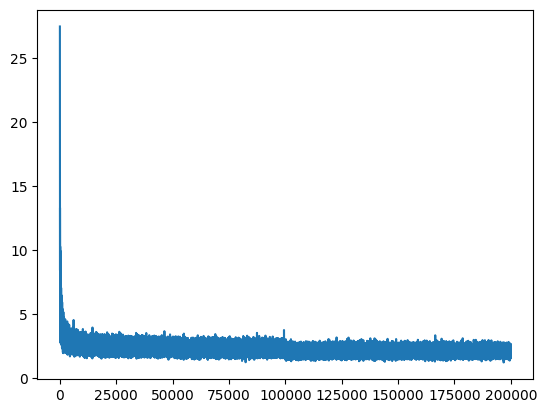

In [110]:
plt.plot([i for i in range(len(lossi))], lossi)

In [111]:
X_DEV, Y_DEV = build_inputs_outputs(words_dev)
X_DEV.shape, Y_DEV.shape

(torch.Size([22633, 3]), torch.Size([22633]))

In [112]:
loss_dev = cal_loss(X_DEV, torch.arange(X_DEV.shape[0]), Y_DEV)
print(f"dev loss: {loss_dev}")

dev loss: 2.3863847255706787


In [113]:
X_TEST, Y_TEST = build_inputs_outputs(words_test)
X_TEST.shape, Y_TEST.shape

(torch.Size([22735, 3]), torch.Size([22735]))

In [114]:
loss_test = cal_loss(X_TEST, torch.arange(X_TEST.shape[0]), Y_TEST)
print(f"test loss: {loss_test}")

test loss: 2.423779010772705


In [117]:
def generate(g):
    input_ids = [0, 0, 0]
    outputs = []
    idx = None
    while idx != 0:
        emb = C[torch.tensor(input_ids)]
        h = torch.tanh(emb.view(1, 30) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        idx = torch.multinomial(probs, num_samples=1, generator=g).item()
        outputs.append(idx)
        input_ids = input_ids[1:] + [idx]
    outputs = [itos[output] for output in outputs]
    return ''.join(outputs)

In [119]:
g_gen = torch.Generator().manual_seed(2147483647)
for i in range(10):
    print(generate(g))

maden.
avim.
aymorlie.
aio.
karle.
joun.
selionah.
lyiah.
tye.
malannahla.
